<a href="https://colab.research.google.com/github/younghun-cha/DM_2022/blob/main/Sentimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naver의 영화 리뷰 데이터를 이용한 감성 분류 모델 구축

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

## 1. 데이터 준비

- 데이터 출처 : https://github.com/e9t/nsmc

In [ ]:
rating_tr = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Mining/data/ratings_train.txt', encoding='utf8', sep='\t', engine='python')
rating_tr.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


- label 클래스의 0은 부정 감성, 1은 긍정 감성

In [ ]:
rating_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [ ]:
# document에 존재하는 결측치 제거
rating_tr = rating_tr.dropna(how='any')
len(rating_tr)

149995

In [ ]:
# 감성 분류 클래스의 구성 확인
rating_tr.label.value_counts()

0    75170
1    74825
Name: label, dtype: int64

In [ ]:
# 한글 이외의 문자는 공백으로 변환
import re

rating_tr['document'] = rating_tr['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
rating_tr.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# test data에도 동일한 처리
rating_te = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data Mining/data/ratings_test.txt", encoding='utf8', sep='\t', engine='python')
rating_te.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
rating_te = rating_te.dropna(how='any')
len(rating_te)

49997

In [ ]:
rating_te['document'] = rating_te['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
rating_te.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


## 2. 피처 벡터화 : TF-IDF

### (1) 형태소를 분석하여 토큰화 : 한글 형태소 엔진으로 Okt 이용

In [ ]:
# colab에서 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip3 install JPype1-py3
!pip3 install konlpy
!JAVA_HOME="C:\Program Files\Java\jdk-18.0.1.1"

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency t

In [ ]:
# !pip install konlpy

In [ ]:
from konlpy.tag import Okt

okt = Okt()

In [ ]:
def okt_tokenizer(text):
  tokens = okt.morphs(text)
  return tokens

### (2) TF-IDF 기반 피처 벡터 생성

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, ngram_range=(1, 2), min_df=3, max_df=0.9)
tfidf.fit(rating_tr['document'])
rating_tr_tfidf = tfidf.transform(rating_tr['document'])

## 3. Sentiment Analysis using Logistic Regression

### (1) 로지스틱 회귀 기반 분석 모델 생성

In [ ]:
from sklearn.linear_model import LogisticRegression
SA_lr = LogisticRegression(random_state=0)

In [ ]:
SA_lr.fit(rating_tr_tfidf, rating_tr['label'])

LogisticRegression(random_state=0)

### (2) 로지스틱 회귀의 best hyper-parameter 찾기

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'C': [1, 3, 3.5, 4, 4.5, 5]}
SA_lr_grid_cv = GridSearchCV(SA_lr, param_grid=params, cv=3, scoring='accuracy', verbose=1)

### (3) 최적 분석 모델 훈련

In [ ]:
SA_lr_grid_cv.fit(rating_tr_tfidf, rating_tr['label'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [1, 3, 3.5, 4, 4.5, 5]}, scoring='accuracy',
             verbose=1)

In [ ]:
print(SA_lr_grid_cv.best_params_, round(SA_lr_grid_cv.best_score_, 4))

{'C': 3} 0.8553


In [ ]:
# 최적 파라미터의 best model 저장
SA_lr_best = SA_lr_grid_cv.best_estimator_

## 4. 분석 모델 평가

### (1) 평가용 데이터를 이용하여 감성 분석 모델 정확도

In [ ]:
# 평가용 데이터의 피처 벡터화
rating_te_tfidf = tfidf.transform(rating_te['document'])

In [ ]:
test_predict = SA_lr_best.predict(rating_te_tfidf)

In [ ]:
from sklearn.metrics import accuracy_score

print("감성 분석 정확도 : ", round(accuracy_score(rating_te['label'], test_predict), 3))

감성 분석 정확도 :  0.858


### (2) 새로운 텍스트에 대한 감성 예측

In [ ]:
st = input("감성 분석할 문장 입력 >> ")

감성 분석할 문장 입력 >> 딱히 대단한 재미도 감동도 없음. 너무 과대 평가된 영화 중 하나임


In [ ]:
# 0) 입력 테스트에 대한 전처리 수행
st = re.compile(r'[ㄱ-ㅣ가-힣]+').findall(st)
print(st)
st = [" ".join(st)]
print(st)

['딱히', '대단한', '재미도', '감동도', '없음', '너무', '과대', '평가된', '영화', '중', '하나임']
['딱히 대단한 재미도 감동도 없음 너무 과대 평가된 영화 중 하나임']


In [ ]:
# 1) 입력 테스트의 피처 벡터화
st_tfidf = tfidf.transform(st)

# 2) 최적 감성 분석 모델에 적용하여 감성 분석 평가
st_predict = SA_lr_best.predict(st_tfidf)

In [ ]:
# 3) 예측 값 출력하기
if(st_predict == 0):
  print(st, "->> 부정 감성")
else:
  print(st, "->> 긍정 감성")

['딱히 대단한 재미도 감동도 없음 너무 과대 평가된 영화 중 하나임'] ->> 부정 감성


# Naver에서 크롤링한 뉴스 데이터로 감성 분석

## 1. 데이터 준비

In [ ]:
import json

with open('/content/drive/MyDrive/Colab Notebooks/Data Mining/data/news.json', encoding='utf8') as j_f:
  data = json.load(j_f)

In [ ]:
print(data)

[{'cnt': 1, 'description': '<b>코로나</b>발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만, 국세 수입은 줄어들면서 정부의 재정 마련에 대한 우려가 컸다. 이 때문에 한국개발원(KDI) 등 국책연구기관들은 증세를 화두로 꺼내들었지만, 정부 여당은 증세에... ', 'pDate': '2020-06-04 14:12:00', 'title': "결국 '증세론' 먼저 꺼내든 與…&quot;증세없는 '기본소득' 불가능&quot;"}, {'cnt': 2, 'description': '▲ 지난 2일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다.©(사진제공=창녕군청) <b>코로나</b> 장기화 대비 비대면 선별진료 도입 경남 창녕군은 지난 2월 28일 도내 최초로 <b>코로나</b>19 선별진료소... ', 'pDate': '2020-06-04 14:12:00', 'title': '창녕군, ‘창녕형’비대면 선별진료소 운영'}, {'cnt': 3, 'description': "한편, ‘설현’은 최근 <b>코로나</b>19 바이러스를 다룬, MBC ‘시리즈M’ PANDEMIC(세계적 유행)에서 다큐멘터리 내레이션에 처음 도전해 호평을 받았으며, tvN의 새 드라마 '낮과 밤' 출연을 검토중이다. 게임과 이벤트에 대한... ", 'pDate': '2020-06-04 14:12:00', 'title': "DK모바일, 메인 홍보 모델로 AOA '설현' 선정"}, {'cnt': 4, 'description': '변화의 핵심 중에서는 우리 사회가 신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19)의 위기를 마주하고 있다. 언제 끝이날 지 또 앞으로 어떠한 미래가 펼치질 지 모른다. 국가가 나서서 국민의 어려움을 해결해 줘야 한다. 저희... ', 'pDate': '2020-06-04 14:12:00', 'title': '김병민 &quot;기본소득도 필요하면 논의 테이블에 올려야&quot; [인터뷰]'}, {'cnt': 5, 

In [ ]:
# 분석할 컬럼을 추출하여 데이터 프레임에 저장
data_title = []
data_description = []

for item in data:
  data_title.append(item['title'])
  data_description.append(item['description'])

In [ ]:
data_title

["결국 '증세론' 먼저 꺼내든 與…&quot;증세없는 '기본소득' 불가능&quot;",
 '창녕군, ‘창녕형’비대면 선별진료소 운영',
 "DK모바일, 메인 홍보 모델로 AOA '설현' 선정",
 '김병민 &quot;기본소득도 필요하면 논의 테이블에 올려야&quot; [인터뷰]',
 '이재갑 장관, 고용안정지원금 서울센터 방문',
 "'부산행'→'반도'로 이어지는 한국형 좀비 세계관, 칸의 선택 받았다",
 "31년만 첫 '불허'에도 홍콩, 톈안문 추모 촛불",
 '국내 3대 항만 4월 물동량 ‘인천항만 상승곡선’',
 '경기도의회 농정해양위, 농민기본소득 도입 이재명 지사와 집행부에 강력 촉구',
 '이용빈 원내부대표 &quot;<b>코로나</b> 대응 의료진·노동자 건강권 보장해야&quot;',
 '<b>코로나</b>19로 인해 변한 원광한의대 경혈학 실습 풍경',
 '경산시 농산물 드라이브 스루 특별할인 판매행사 개최',
 '당신이 아는 미술, 시장이 아는 미술 ④ 한국 현대 미술 시장을 이끄는 작가',
 '제25회 부산국제영화제 공식 상영작 모집 [공식]',
 '수도권 <b>코로나</b>19 확진자 산발적으로 늘어…하루 새 47명 증가',
 '동작구, 전통시장 무료 배송서비스 사업 실시',
 '서울 건강용품 세미나서 무더기 확진…199명 검사',
 'BBQ, 상반기 신입 및 경력직 공채 시행',
 '중국 굴착기 판매량 상승에도...두산인프라코어 긴장하는 이유는',
 '미소짓는 의료진',
 "'포스트 <b>코로나</b>' 대비…M&amp;A·투자 잰걸음 나서는 게임사",
 "휴넷, 리더십 게임러닝 프로그램 '아르고' 출시",
 '광주 서구 양동, 민·관 협력으로 주거환경 개선',
 '손흥민의 고백, “3주간의 군사훈련, 힘들지만 즐겼다”',
 '靑 “카타르 LNG선 수주, 문 대통령 경제외교 결실”',
 '[유통÷나누기 세상＋더하기] 세븐일레븐, 유치원 통학차량에 공기청정기 설치...',
 '김포 혁신교육지구 사업, 특수교육대상자를 위한 교육과정 지원'

In [ ]:
data_description

['<b>코로나</b>발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만, 국세 수입은 줄어들면서 정부의 재정 마련에 대한 우려가 컸다. 이 때문에 한국개발원(KDI) 등 국책연구기관들은 증세를 화두로 꺼내들었지만, 정부 여당은 증세에... ',
 '▲ 지난 2일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다.©(사진제공=창녕군청) <b>코로나</b> 장기화 대비 비대면 선별진료 도입 경남 창녕군은 지난 2월 28일 도내 최초로 <b>코로나</b>19 선별진료소... ',
 "한편, ‘설현’은 최근 <b>코로나</b>19 바이러스를 다룬, MBC ‘시리즈M’ PANDEMIC(세계적 유행)에서 다큐멘터리 내레이션에 처음 도전해 호평을 받았으며, tvN의 새 드라마 '낮과 밤' 출연을 검토중이다. 게임과 이벤트에 대한... ",
 '변화의 핵심 중에서는 우리 사회가 신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19)의 위기를 마주하고 있다. 언제 끝이날 지 또 앞으로 어떠한 미래가 펼치질 지 모른다. 국가가 나서서 국민의 어려움을 해결해 줘야 한다. 저희... ',
 '\xa0이재갑\xa0고용노동부\xa0장관은\xa06월3일(수)\xa011시에\xa0<b>코로나</b>19\xa0긴급\xa0고용안정지원금\xa0서울\xa01센터(서울\xa0중구)를\xa0방문했다. 이번\xa0현장\xa0방문은\xa0<b>코로나</b>19\xa0긴급\xa0고용안정지원금\xa0신청을\xa0시작한\xa0지\xa0이틀\xa0만에\xa0약\xa012만건... ',
 "하지만 올해 신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19) 여파로 오프라인 행사를 진행하지 않게 되었고, 공식 채널(Canal +)을 통해 ‘Cannes Official Selection 2020’ 명칭의 초청작 리스트를 공개했다. 한편 '반도'는 7월 국내외... ",
 '경찰은 <b>코로나</b>19 감염이 우려된다며 8명 이상을 모이는 집회를 봉쇄해왔고 지난 홍콩 국가보안법

In [ ]:
data_df = pd.DataFrame({'title': data_title, 'description': data_description})

In [ ]:
# 한글 이외 문자 제거
data_df['title'] = data_df['title'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))
data_df['description'] = data_df['description'].apply(lambda x : re.sub(r'[^ ㄱ-ㅣ가-힣]+', " ", x))

data_df.head()  # 작업 확인용 출력

,title,description
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 코로나 바이러스 감염증 코로나 의 위기를 ...
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 코로나 긴급 고용안정지원금 서울 센터 서...


## 2. 감성 분석 수행

### (1) 'title'에 대한 감성 분석

In [ ]:
# 1) 분석할 데이터의 피처 벡터화 ---<< title >> 분석
data_title_tfidf = tfidf.transform(data_df['title'])

# 2) 최적 파라미터 학습 모델에 적용하여 감성 분석
data_title_predict = SA_lr_best.predict(data_title_tfidf)

# 3) 감성 분석 결과값을 데이터 프레임에 저장
data_df['title_label'] = data_title_predict

### (2) 'description'에 대한 감성 분석

In [ ]:
# 1) 분석할 데이터의 피처 벡터화 ---<< description >> 분석
data_description_tfidf = tfidf.transform(data_df['description'])

# 2) 최적 파라미터 학습 모델에 적용하여 감성 분석
data_description_predict = SA_lr_best.predict(data_description_tfidf)

# 3) 감성 분석 결과값을 데이터 프레임에 저장
data_df['description_label'] = data_description_predict

## 3. 감성 분석 결과 확인 - 0: 부정 감성, 1: 긍정 감성

In [ ]:
# 감성 분석 결과 확인
data_df.head()

,title,description,title_label,description_label
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,코로나 발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서...,0,0
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...,0,0
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 코로나 바이러스를 다룬 시리즈 세계적 유행 에...,0,0
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 코로나 바이러스 감염증 코로나 의 위기를 ...,0,1
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 코로나 긴급 고용안정지원금 서울 센터 서...,0,0


In [ ]:
print(data_df['title_label'].value_counts())

0    485
1    315
Name: title_label, dtype: int64


In [ ]:
print(data_df['description_label'].value_counts())

0    430
1    370
Name: description_label, dtype: int64


In [ ]:
columns_name = ['title','title_label','description','description_label']
NEG_data_df = pd.DataFrame(columns=columns_name)
POS_data_df = pd.DataFrame(columns=columns_name)

for i, data in data_df.iterrows():
  title = data["title"]
  description = data["description"]
  t_label = data["title_label"]
  d_label = data["description_label"]

  if d_label == 0:  # 부정 감성 샘플만 추출
    NEG_data_df = NEG_data_df.append(pd.DataFrame([[title, t_label, description, d_label]], columns=columns_name), ignore_index=True)
  else :  # 긍정 감성 샘플만 추출
    POS_data_df = POS_data_df.append(pd.DataFrame([[title, t_label, description, d_label]], columns=columns_name), ignore_index=True)

In [ ]:
len(NEG_data_df), len(POS_data_df)

(430, 370)

## 4. 감성 분석 결과 시각화 : 막대 도표

### (1) 명사만 추출하여 정리하기

In [ ]:
# 긍정 감성의 데이터에서 명사만 추출하여 정리
POS_description = POS_data_df['description']
POS_description_noun_tk = []

for d in POS_description:
  POS_description_noun_tk.append(okt.nouns(d))  # 형태소가 명사인 것만 추출

print(POS_description_noun_tk)  # 작업 확인용 출력

[['변화', '핵심', '중', '우리', '사회', '신종', '코로나', '바이러스', '감염증', '코로나', '의', '위기', '마주', '언제', '끝', '날', '또', '앞', '미래', '국가', '국민', '어려움', '해결', '저희'], ['한편', '코로나', '로', '해외', '식', '재료', '사재기', '국민', '먹거리', '안정', '생산', '것', '포스트', '코로나', '의', '과제', '부각', '농민', '기본소득', '도입', '통해', '안정', '생산', '기반', '확충', '것'], ['최근', '갤러리', '현대', '창업', '주년', '기념', '전', '이', '작품', '전시', '코로나', '의', '영향', '마스크', '착용', '관람객', '미술', '트렌드', '한국', '미술', '시장', '글', '정태희', '서울', '옥션', '스페셜리스트', '세계', '경기', '침체', '코로나', '여파'], ['코로나', '감안', '차', '면접', '비대', '역량', '검사', '도입', '국내', '최대', '치킨', '프랜차이즈', '제너시스', '비비큐', '회장', '채용', '관계자', '한국', '대표', '책임감', '브랜드', '로서', '코로나', '로', '침체', '채용', '분위기'], ['일', '오후', '서울', '중랑구', '의료', '의료', '잠시', '콘서트', '신종', '코로나', '바이러스', '감염증', '코로나', '환자', '진료', '위해', '수고', '온', '의료', '진', '가수', '폴', '킴', '공연', '보고', '뉴스'], ['플립', '러닝', '온라인', '학습', '후', '교실', '토론', '및', '심화', '학습', '거꾸로', '교실', '불리', '포스트', '코로나', '시대', '교육', '방식', '주목', '아르고', '리더십', '편', '상황', '게임', '통해', '리더십', '유형

In [ ]:
POS_description_noun_join = []

for d in POS_description_noun_tk:
  d2 = [w for w in d if len(w) > 1]  # 길이가 1인 토큰은 제외
  POS_description_noun_join.append(" ".join(d2))  # 토큰을 연결(join)하여 리스트 구성

print(POS_description_noun_join)  # 작업 확인용 출력

['변화 핵심 우리 사회 신종 코로나 바이러스 감염증 코로나 위기 마주 언제 미래 국가 국민 어려움 해결 저희', '한편 코로나 해외 재료 사재기 국민 먹거리 안정 생산 포스트 코로나 과제 부각 농민 기본소득 도입 통해 안정 생산 기반 확충', '최근 갤러리 현대 창업 주년 기념 작품 전시 코로나 영향 마스크 착용 관람객 미술 트렌드 한국 미술 시장 정태희 서울 옥션 스페셜리스트 세계 경기 침체 코로나 여파', '코로나 감안 면접 비대 역량 검사 도입 국내 최대 치킨 프랜차이즈 제너시스 비비큐 회장 채용 관계자 한국 대표 책임감 브랜드 로서 코로나 침체 채용 분위기', '오후 서울 중랑구 의료 의료 잠시 콘서트 신종 코로나 바이러스 감염증 코로나 환자 진료 위해 수고 의료 가수 공연 보고 뉴스', '플립 러닝 온라인 학습 교실 토론 심화 학습 거꾸로 교실 불리 포스트 코로나 시대 교육 방식 주목 아르고 리더십 상황 게임 통해 리더십 유형', '도배 장판 침대 장롱 가구 교체 코로나 예방 방역 진행 주거 환경 조성 미자 양동 동장 이웃 위해 봉사', '코로나 사태 가운데 병영 생활 손흥민 경험 영국 화제 손흥민 서로 금방 이서 정말 서로 호흡', '청와대 해외 보가 문재인 대통령 포스트 코로나 시대 경제위기 정상회담 통해 양국 협력 에너지 의료 확장 최근 카타르 코로나 관련', '맥도날드 코로나 방역 작업 대구 지하철 청소 근로자 빅맥 커피 증정 패션 업계 나눔 활동 동참 코오롱 인더스 트리 직원 성과 상금 만원 코로나 어려움', '정하영 김포시 혁신 교육 지구 사업 특수교육 대상자 사업 별도 편성 소외 학생 면서 코로나 교육과정 운영 판단 학생 안전 방역', '군포 시청 서울시 리치 웨이 코로나 진자 동선 공개 군포로 번길 거주 자료 군포 시청 군포 시청 서울시 리치 웨이 코로나 진자 동선 공개 군포 시청 공식 블로그 통해 서울시', '명품 함양 양파 특판전 모습 사진 제공 함양군 함양군 롯데 마트 서울 역점 양파 소비 촉진 판촉 행사 코로나 농심 위로 함양군

In [ ]:
# 부정 감성의 데이터에서 명사만 추출하여 정리
NEG_description = NEG_data_df['description']

NEG_description_noun_tk = []
NEG_description_noun_join = []

for d in NEG_description:
  NEG_description_noun_tk.append(okt.nouns(d))  # 형태소가 명사인 것만 추출

for d in NEG_description_noun_tk:
  d2 = [w for w in d if len(w) > 1]  # 길이가 1인 토큰은 제외
  NEG_description_noun_join.append(" ".join(d2))  # 토큰을 연결(join)하여 리스트 구성

print(NEG_description_noun_join)  # 작업 확인용 출력

['코로나 경제 위기 대응 위해 국세 수입 정부 재정 마련 대한 우려 때문 한국 개발 국책 연구기관 증세 화두 정부 여당 증세', '지난 창녕군 보건소 설치 진료 검사 체온 측정 사진 제공 창녕군 코로나 장기 대비 비대 진료 도입 경남 창녕군 지난 도내 최초 코로나 진료', '한편 설현 최근 코로나 바이러스 시리즈 세계 유행 다큐멘터리 내레이션 처음 도전 호평 드라마 출연 검토 게임 이벤트 대한', '이재 고용노동부 장관 코로나 긴급 고용 안정 원금 서울 센터 서울 중구 방문 이번 현장 방문 코로나 긴급 고용 안정 원금 신청 시작 이틀', '올해 신종 코로나 바이러스 감염증 코로나 여파 오프라인 행사 진행 공식 채널 통해 명칭 초청 리스트 공개 한편 반도 국내외', '경찰 코로나 감염 우려 이상 집회 봉쇄 지난 홍콩 국가보안법 시위 홍콩 경찰 코로나 확산 올해 불허 상황 처음 주최', '전국 컨테이너 처리 국내 항만 신종 코로나 바이러스 감염증 코로나 사태 본격 물동량 부진 와중 인천 중국 항만 정상화', '이용 의원 제공 이용 민주당 내부 대표 코로나 시화 장기 생활 방역 면서 코로나 현장 의료 진의 근무 환경 부당 처우 과중 노동 강도 인력 부족 문제', '코로나 사태 지속 한의대 강의 역시 대부분 대면 대면 실습 강의실 풍경 예전 현재 코로나 대부분 학과 수업 대면', '이번 행사 코로나 확대 장기 화로 지역 소비 판로 어려움 농가 돕기 소비 촉진 위해 마련 행사 계란 연근 감자 새송이 방울토마토 깻잎 양파 오이 고추 품목', '세계 코로나 전례 위기 이로 국내외 영화계 예상 타격 부산 국제 영화제 국내외 상황 인지 예의 주시 정부 방침 권고 준수', '서울 경기 인천 수도권 개척 교회 신종 코로나 바이러스 감염증 코로나 진자 산발 증가 모양새 감염 경로 진자 방역 당국 긴장', '신종 코로나 바이러스 감염증 코로나 장기 화로 전통 시장 상인 매출 감소 점포 운영 어려움 투입 오프라인 무료 배송 서비스 운영 지원 지원 대상 남성 사계 시장', '수도권 중

### (2) DTM 구축

In [ ]:
# 긍정 감성 데이터에 대한 dtm 구성, dtm을 이용하여 단어사전 구성 후 내림차순 정렬
POS_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)
POS_vocab = dict()

for idx, word in enumerate(POS_tfidf.get_feature_names()):
  POS_vocab[word] = POS_dtm.getcol(idx).sum()

POS_words = sorted(POS_vocab.items(), key=lambda x: x[1], reverse=True)
POS_words  # 작업 확인용 출력

[('코로나', 29.58865817494428),
 ('의료', 13.461836434575911),
 ('위해', 11.469142512665115),
 ('바이러스', 9.626197092990505),
 ('신종', 9.241355937335499),
 ('감염증', 8.876275469712054),
 ('온라인', 7.6638009611810896),
 ('시대', 7.638747100423279),
 ('확산', 7.462304300911354),
 ('사회', 7.331187766652533),
 ('이번', 6.953637262299177),
 ('지역', 6.7931464306235565),
 ('어려움', 6.57884559465247),
 ('통해', 6.500569971401247),
 ('극복', 6.067323212381158),
 ('포스트', 6.02648184365831),
 ('기업', 5.899827006908783),
 ('서울', 5.432782197187217),
 ('사태', 5.340689961243574),
 ('방역', 5.308659591090857),
 ('최근', 5.285143543921558),
 ('언택트', 5.185701361355053),
 ('상황', 5.129043847943381),
 ('환자', 5.111079129368619),
 ('정부', 5.069719087512996),
 ('사업', 5.045688264465154),
 ('경제', 5.043712031592348),
 ('생활', 5.034230080207947),
 ('대표', 5.031840422108942),
 ('올해', 5.011379038211078),
 ('공연', 4.936538589036854),
 ('우리', 4.898794126455551),
 ('비대', 4.802827030463792),
 ('한국', 4.770201020213962),
 ('개발', 4.767977722488553),
 ('진자', 4.

In [ ]:
# 부정 감성 데이터의 dtm 구성, dtm을 이용하여 단어사전 구성 후 내림차순 정렬
NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)
NEG_vocab = dict()

for idx, word in enumerate(NEG_tfidf.get_feature_names()):
  NEG_vocab[word] = NEG_dtm.getcol(idx).sum()

NEG_words = sorted(NEG_vocab.items(), key=lambda x: x[1], reverse=True)
NEG_words  # 작업 확인용 출력

[('코로나', 34.56440043805242),
 ('바이러스', 15.755970871602138),
 ('신종', 14.29640382643984),
 ('감염증', 14.034156174169826),
 ('위해', 11.557221696267494),
 ('확산', 9.566148700015386),
 ('대종상영화제', 9.131196736061566),
 ('사태', 8.511012953112722),
 ('진행', 8.501455300356248),
 ('지역', 8.02051798313098),
 ('방역', 7.786170139849359),
 ('지난', 7.563662184925654),
 ('참석', 7.320037542811409),
 ('진자', 7.019841914588245),
 ('이번', 6.942817107419809),
 ('여파', 6.7290204781835925),
 ('감염', 6.669203919601509),
 ('지원', 6.501810225977662),
 ('예방', 6.39663153382676),
 ('경제', 5.6993577091405525),
 ('최근', 5.577762429272219),
 ('서울', 5.119380466737213),
 ('생활', 5.040220383692727),
 ('마스크', 4.990391941347541),
 ('대응', 4.958683224918504),
 ('장기', 4.865605387946561),
 ('가운데', 4.806733078391168),
 ('정부', 4.690520671438856),
 ('상황', 4.67552454891047),
 ('시장', 4.660874586002851),
 ('어려움', 4.633706079944705),
 ('발생', 4.558656374995721),
 ('로봇', 4.52985529979186),
 ('운영', 4.52088415417818),
 ('위기', 4.498382001461058),
 ('클라우드',

### (3) 단어사전의 상위 단어로 bar chart 그리기

In [ ]:
# colab에 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -qq

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fm._rebuild()
fm.get_fontconfig_fonts()
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

max = 15  # bar chart에 나타낼 단어의 수

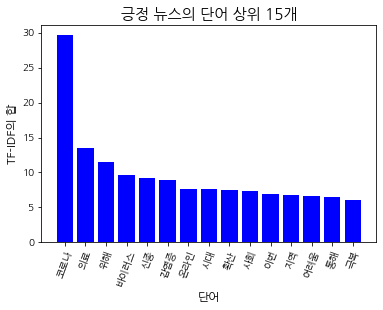

In [ ]:
plt.bar(range(max), [i[1] for i in POS_words[:max]], color="blue")
plt.title("긍정 뉴스의 단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation=70)

plt.show()

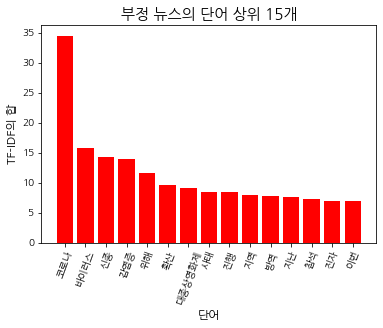

In [ ]:
plt.bar(range(max), [i[1] for i in NEG_words[:max]], color="red")
plt.title("부정 뉴스의 단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in NEG_words[:max]], rotation=70)

plt.show()